In [2]:
%reload_ext autoreload
%autoreload 3

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

import torch
import torchmetrics
import pytorch_lightning as pl
import pandas as pd
from src.cogponder import CogPonderModel
from src.cogponder.datasets import StroopSRODataset, CogPonderDataModule
from pathlib import Path

In [4]:
# this notebook only fits one SRO subject, which its SRO-SubjectID can be defined here
SRO_SUBJECT_ID = 202

# upon successful training, the model will be saved to this path
CHECKPOINT_PATH = Path('models/stroop/') / f'cogponder_subject-{SRO_SUBJECT_ID}_epochs-10000.ckpt'

BATCH_SIZE = 72

In [8]:
# DEBUG

# DEBUG - Load the checkpoint

model_ckpt = CogPonderModel.load_from_checkpoint(CHECKPOINT_PATH)
model_ckpt.eval()

print('loading data module...', end='')
dataset = StroopSRODataset(n_subjects=-1, response_step_interval=10)
data = dataset[SRO_SUBJECT_ID]
datamodule = CogPonderDataModule(data, batch_size=BATCH_SIZE, num_workers=8)
datamodule.prepare_data()
print('Done!')

X_train, trial_types_train, is_corrects_train, y_train, rt_train = datamodule.train_dataset[:]
X_test, trial_types_test, is_corrects_test, y_test, rt_test = datamodule.test_dataset[:]

with torch.no_grad():
    model_ckpt.eval()

    print('Predicting responses...', end='')
    y_train_steps,p_train,rt_train_pred = model_ckpt(X_train)
    y_test_steps,p_test,rt_test_pred = model_ckpt(X_test)

    y_train_steps = torch.argmax(y_train_steps, dim=-1)
    y_test_steps = torch.argmax(y_test_steps, dim=-1)

    y_train_pred = y_train_steps.gather(dim=0, index=rt_train_pred[None, :] - 1,)[0]  # (batch_size,)
    y_test_pred = y_test_steps.gather(dim=0, index=rt_test_pred[None, :] - 1,)[0]  # (batch_size,)

    print('Done!')


loading data module...Done!
Predicting responses...Done!


/home/morteza/mambaforge/envs/ponder/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/morteza/mambaforge/envs/ponder/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


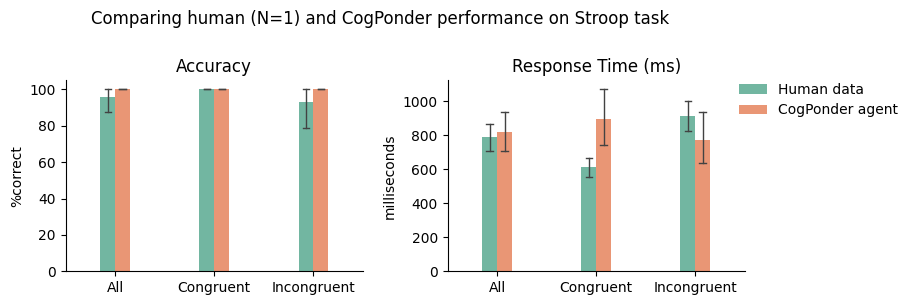

In [9]:
non_decision_time = (
    dataset.non_decision_time[SRO_SUBJECT_ID] + dataset.response_step_interval * data[4].min()
)

average_human_performance = pd.DataFrame({
    'condition': -1,
    'response_time': rt_test * dataset.response_step_interval + non_decision_time,
    'accuracy': (X_test[:,1] == y_test).float() * 100,
    'agent': 'Human data',
})

human_performance = pd.DataFrame({
    'condition': trial_types_test,
    'response_time': rt_test * dataset.response_step_interval + non_decision_time,
    'accuracy': (X_test[:,1] == y_test).float() * 100,
    'agent': 'Human data',
})

cogponder_performance = pd.DataFrame({
    'condition': trial_types_test,
    'response_time': rt_test_pred * dataset.response_step_interval + non_decision_time,
    'accuracy': (X_test[:,1] == y_test_pred).float() * 100,
    'agent': 'CogPonder agent'
})

average_cogponder_performance = pd.DataFrame({
    'condition': -1,
    'response_time': rt_test_pred * dataset.response_step_interval + non_decision_time,
    'accuracy': (X_test[:,1] == y_test_pred).float() * 100,
    'agent': 'CogPonder agent',
})

plot_data = pd.concat([human_performance, average_human_performance,
                       cogponder_performance, average_cogponder_performance]).reset_index()

plot_data['condition'] = plot_data['condition'].map({-1: 'All', 0: 'Incongruent', 1: 'Congruent'})

plot_data = plot_data.melt(id_vars=['index', 'condition', 'agent'],
               value_vars=['response_time', 'accuracy'],
               var_name='measure'
               )


/home/morteza/mambaforge/envs/ponder/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/morteza/mambaforge/envs/ponder/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


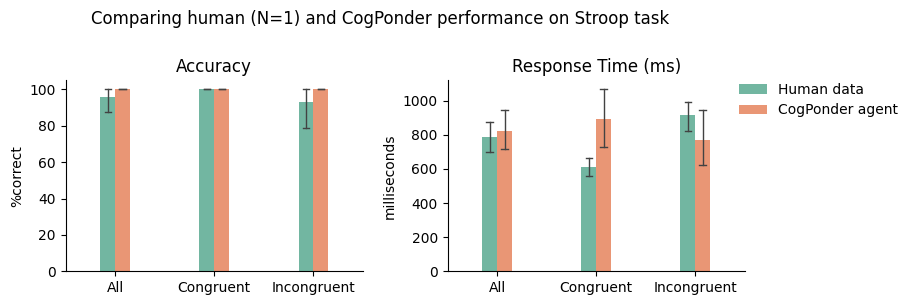

In [10]:
g = sns.FacetGrid(
    data=plot_data, col='measure',
    palette='Blues',
    col_order=['accuracy', 'response_time'],
    sharey=False, sharex=False, height=3, aspect=1)

g.map(sns.barplot, 'condition', 'value', 'agent',
      width=.3,
      order=['All', 'Congruent', 'Incongruent'],
      hue_order=['Human data', 'CogPonder agent'],
      errorbar=('ci', 95), capsize=.065, errwidth=1,
      palette='Set2')

g.add_legend(loc='upper left', bbox_to_anchor=(.95, .8))

g.axes[0,0].set_ylabel('%correct')
g.axes[0,0].set_title('Accuracy')
g.axes[0,1].set_ylabel('milliseconds')
g.axes[0,1].set_title('Response Time (ms)')
g.axes[0,0].set_xlabel(None)
g.axes[0,1].set_xlabel(None)


plt.suptitle('Comparing human (N=1) and CogPonder performance on Stroop task', y=1)
plt.tight_layout()
plt.savefig('outputs/figures/figure3.png', bbox_inches='tight', dpi=300)
plt.show()